Data from kaggle dataset: https://www.kaggle.com/datasets/hijest/englishrussian-dictionary-for-machine-translate

I used transformer from keras_nlp for this task

In [ ]:
import pandas as pd
import numpy as np
import time
import gc
from tqdm import tqdm
!pip install keras_nlp
import keras_nlp
import pathlib
import random
import tensorflow as tf

from tensorflow import keras
from tensorflow_text.tools.wordpiece_vocab import (
    bert_vocab_from_dataset as bert_vocab,
)

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
!pip install pymorphy2
import pymorphy2
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('stopwords')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 63.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 62.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=a9c1d37e417da8bc153fd8d73d7f983b0b6d11e910922ff72ca9b1cfbcc0d355
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
#!pip install feather-format >> none
#!pip install faiss-cpu --no-cache

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sorokinmaksim","key":"9537fa921e351600c84c9f61d1f01441"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 69 Apr  2 12:25 kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hijest/englishrussian-dictionary-for-machine-translate

 84% 10.0M/11.9M [00:00<00:00, 15.8MB/s]
100% 11.9M/11.9M [00:00<00:00, 13.0MB/s]


In [ ]:
! unzip /content/englishrussian-dictionary-for-machine-translate.zip

Archive:  /content/englishrussian-dictionary-for-machine-translate.zip
  inflating: rus.txt                 


In [ ]:
translation_data = pd.read_csv('rus.txt', delimiter='\t', header=None)
translation_data = translation_data[[0, 1]]
translation_data.columns=['eng', 'rus']
translation_data

,eng,rus
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!
...,...,...
363381,"In today's world, we have to equip all our kid...",В современном мире перед нами стоит задача дат...
363382,Death is something that we're often discourage...,"Смерть - это зачастую то, разговоры или даже м..."
363383,"At a moment when our economy is growing, our b...","В тот момент, когда наша экономика растёт, наш..."
363384,Since there are usually multiple websites on a...,"Поскольку сайтов, посвящённых какой-либо теме,..."


In [ ]:
translation_data = translation_data.applymap(lambda x: x.lower())
translation_data

,eng,rus
0,go.,марш!
1,go.,иди.
2,go.,идите.
3,hi.,здравствуйте.
4,hi.,привет!
...,...,...
363381,"in today's world, we have to equip all our kid...",в современном мире перед нами стоит задача дат...
363382,death is something that we're often discourage...,"смерть - это зачастую то, разговоры или даже м..."
363383,"at a moment when our economy is growing, our b...","в тот момент, когда наша экономика растёт, наш..."
363384,since there are usually multiple websites on a...,"поскольку сайтов, посвящённых какой-либо теме,..."


In [ ]:
# news_data.isna().sum()

In [ ]:
# target_classes = news_data['category'].unique()
# target_classes

In [ ]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
morph = pymorphy2.MorphAnalyzer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):    
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    list_of_words = []
    # for tag in word_pos_tags:
    #     if tag[1] != 'NONLEX':
    #         list_of_words.append(morph.normal_forms(tag[0])[0])
    #     else:
    #         list_of_words.append(tag[0])
    # word_pos_tags = nltk.pos_tag(list_of_words) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in word_pos_tags] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [ ]:
# %%time
# def finalpreprocess(string):
#     return lemmatizer(stopword(preprocess(string)))
# news_data['headline'] = news_data['headline'].apply(lambda x: finalpreprocess(x))
# news_data.head()

In [ ]:
# print(len(news_data[news_data['headline'] == ""]))

In [ ]:
# news_data = news_data.loc[news_data['headline'] != ""]
# print(len(news_data[news_data['headline'] == ""]))

In [ ]:
train_data, test_data = train_test_split(translation_data, test_size=0.3)
[train_data.shape, test_data.shape]

[(254370, 2), (109016, 2)]

In [ ]:
# news_data.isna().sum()

In [ ]:
# train_data.to_csv('train.csv', index=False)
# test_data.to_csv('test.csv', index=False)

In [ ]:
#train_data = pd.read_csv('train.csv')
#test_data = pd.read_csv('test.csv')

In [ ]:
#full_data = pd.concat([train_data, test_data])
#full_data

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10  # This should be at least 10 for convergence
MAX_SEQUENCE_LENGTH = 40
ENG_VOCAB_SIZE = 20000
RUS_VOCAB_SIZE = 20000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

In [ ]:
X_val, X_test , y_val, y_test= train_test_split(test_data['eng'],test_data['rus'], test_size=0.5, random_state=42)

In [ ]:
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [ ]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

eng_samples = train_data['eng']
eng_vocab = train_word_piece(eng_samples, ENG_VOCAB_SIZE, reserved_tokens)

rus_samples = train_data['rus']
rus_vocab = train_word_piece(rus_samples, RUS_VOCAB_SIZE, reserved_tokens)

In [ ]:
print("English Tokens: ", eng_vocab[1000:1010])
print("Russian Tokens: ", rus_vocab[1000:1010])

English Tokens:  ['takes', 'yes', 'carefully', 'information', 'seemed', 'waste', 'sound', 'telephone', 'dressed', 'forgotten']
Russian Tokens:  ['твою', '##ем', 'выйти', 'другу', 'обо', 'остался', 'погода', 'странно', 'вашего', 'внимания']


In [ ]:
eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=False
)
rus_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=rus_vocab, lowercase=False
)

In [ ]:
ensure_ascii=False

In [ ]:
eng_input_ex = train_data['eng'][train_data.index[5]]
eng_tokens_ex = eng_tokenizer.tokenize(eng_input_ex)
print("English sentence: ", eng_input_ex)
print("Tokens: ", eng_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    eng_tokenizer.detokenize(eng_tokens_ex),
)

print()

rus_input_ex = train_data['rus'][train_data.index[5]]
rus_tokens_ex = rus_tokenizer.tokenize(rus_input_ex)
print("Spanish sentence: ", rus_input_ex)
print("Tokens: ", rus_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    rus_tokenizer.detokenize(rus_tokens_ex).numpy().decode('utf-8'),
)

English sentence:  are you claustrophobic, too?
Tokens:  tf.Tensor([  93   71 3471  747 4468 1610 4455 1047   11  170   27], shape=(11,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'are you claustrophobic , too ?', shape=(), dtype=string)

Spanish sentence:  у тебя тоже клаустрофобия?
Tokens:  tf.Tensor([   79   120   287    70   904  5276  6928   311 10585    26], shape=(10,), dtype=int32)
Recovered text after detokenizing:  у тебя тоже клаустрофобия ?


In [ ]:
def preprocess_batch(eng, rus):
    batch_size = tf.shape(rus)[0]

    eng = eng_tokenizer(eng)
    rus = rus_tokenizer(rus)

    # Pad `eng` to `MAX_SEQUENCE_LENGTH`.
    eng_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=eng_tokenizer.token_to_id("[PAD]"),
    )
    eng = eng_start_end_packer(eng)

    # Add special tokens (`"[START]"` and `"[END]"`) to `spa` and pad it as well.
    rus_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=rus_tokenizer.token_to_id("[START]"),
        end_value=rus_tokenizer.token_to_id("[END]"),
        pad_value=rus_tokenizer.token_to_id("[PAD]"),
    )
    rus = rus_start_end_packer(rus)

    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": rus[:, :-1],
        },
        rus[:, 1:],
    )


def make_dataset(eng, rus):
    eng_texts = list(eng)
    rus_texts = list(rus)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, rus_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_data['eng'], train_data['rus'])
val_ds = make_dataset(X_val, y_val)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 40)
inputs["decoder_inputs"].shape: (64, 40)
targets.shape: (64, 40)


In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=3, min_delta=0.0001)


encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ENG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=RUS_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(RUS_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="transformer",
)
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding (  (None, None, 256)   5130240     ['encoder_inputs[0][0]']         
 TokenAndPositionEmbedding)                                                                       
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   1315072     ['token_and_position_em

In [ ]:
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=early_stop )

Epoch 1/10
3975/3975 [==============================] - 402s 97ms/step - loss: 3.1719 - accuracy: 0.5514 - val_loss: 2.4068 - val_accuracy: 0.6319
Epoch 2/10
3975/3975 [==============================] - 362s 91ms/step - loss: 2.4127 - accuracy: 0.6381 - val_loss: 2.1863 - val_accuracy: 0.6632
Epoch 3/10
3975/3975 [==============================] - 360s 91ms/step - loss: 2.2679 - accuracy: 0.6601 - val_loss: 2.1455 - val_accuracy: 0.6729
Epoch 4/10
3975/3975 [==============================] - 360s 91ms/step - loss: 2.1993 - accuracy: 0.6715 - val_loss: 2.1112 - val_accuracy: 0.6811
Epoch 5/10
3975/3975 [==============================] - 360s 91ms/step - loss: 2.1386 - accuracy: 0.6809 - val_loss: 2.0801 - val_accuracy: 0.6874
Epoch 6/10
3975/3975 [==============================] - 360s 91ms/step - loss: 2.0878 - accuracy: 0.6884 - val_loss: 2.0737 - val_accuracy: 0.6894
Epoch 7/10
3975/3975 [==============================] - 360s 90ms/step - loss: 2.0405 - accuracy: 0.6951 - val_loss: 2

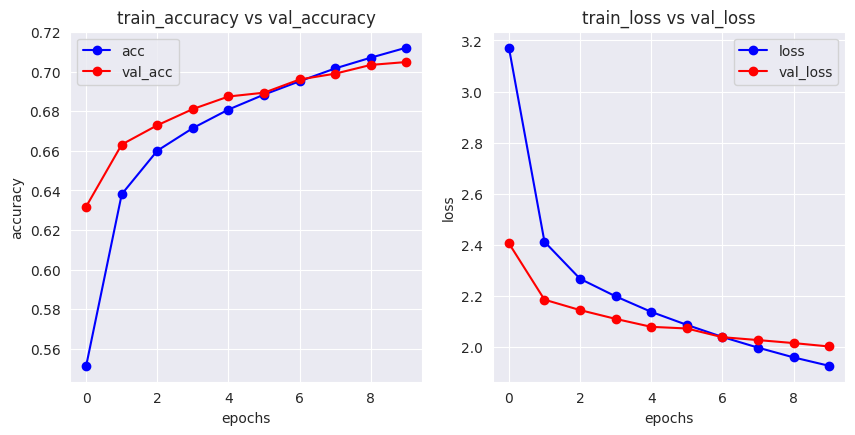

In [ ]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

In [ ]:
def decode_sequences(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    # Tokenize the encoder input.
    encoder_input_tokens = eng_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(decoder_input_tokens):
        return transformer([encoder_input_tokens, decoder_input_tokens])[:, -1, :]

    # Set the prompt to the "[START]" token.
    prompt = tf.fill((batch_size, 1), rus_tokenizer.token_to_id("[START]"))

    generated_tokens = keras_nlp.utils.top_p_search(
        token_probability_fn,
        prompt,
        p=0.1,
        max_length=40,
        end_token_id=rus_tokenizer.token_to_id("[END]"),
    )
    generated_sentences = rus_tokenizer.detokenize(generated_tokens)
    return generated_sentences


test_eng_texts = X_test
for i in range(2):
    input_sentence = test_eng_texts[test_eng_texts.index[random.randint(0,test_eng_texts.shape[0])]]
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(translated)
    print()

** Example 0 **
by the way, i have a boyfriend.
кстати , у меня есть парень .

** Example 1 **
tom told me mary wouldn't want to play volleyball with us.
том сказал мне , что мэри не хотят играть с нами ввежд .



In [ ]:
!python -m rouge.rouge \
    --target_filepattern=*.targets \
    --prediction_filepattern=*.decodes \
    --output_filename=scores.csv \
    --use_stemmer=true \
    --split_summaries=true

/usr/bin/python3: Error while finding module specification for 'rouge.rouge' (ModuleNotFoundError: No module named 'rouge')


In [ ]:
!pip install -r rouge/requirements.txt
!pip install rouge-score

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'rouge/requirements.txt'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q rouge-score
!pip install -q git+https://github.com/keras-team/keras-nlp.git --upgrade

  Preparing metadata (setup.py) ... done


In [ ]:
from rouge_score import rouge_scorer

In [ ]:
#rouge_1 = keras_nlp.metrics.RougeN(order=1)
#rouge_2 = keras_nlp.metrics.RougeN(order=2)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'])

for index in range(30):
    input_sentence = X_test[X_test.index[index]]
    reference_sentence = y_test[y_test.index[index]]

    translated_sentence = decode_sequences(tf.constant([input_sentence]))
    translated_sentence = translated_sentence.numpy()[0].decode("utf-8")
    translated_sentence = (
        translated_sentence.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(reference_sentence, translated_sentence)
    scores = scorer.score(reference_sentence, translated_sentence)
print("ROUGE Scores: ", scores)

у неё было счастливое детство. у неё были счастливые .
тому надо было запереть дверь. тому надо было приходит на дверь .
сдачу оставьте себе. непрогайте .
я одолжу тебе те немногие деньги, которые у меня есть с собой. я дам тебе , если у меня есть на то , что я знаю .
я не знаю, как его зовут. я не знаю его имени .
том и джон всегда ходят на работу в галстуках. том и джон всегда влабобе , что влааре на работу .
мы их больше не используем. мы с ним больше не воспользоваться .
это не мой велосипед. это не мой велосипед .
я доберусь туда раньше тебя. я буду там раньше тебя .
я не знал, что тому надо это сделать. я не знал , что тому надо это сделать .
она ушла из компании. она бросила в компанию .
ты всё ещё в постели? ты всё ещё в постели ?
нас преследует полиция. полиция нас сланди .
уложите ребёнка в постель. усвобвы с дай на нашей семье .
оно было найдено на дне реки. было найти ре .
от них плохо пахнет. они пятят .
это будет сложно. это будет сложно .
это просто нормальный здравый см